In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt

# TP1 Aprendizaje Profundo

Se desea construir un sistema de recomendación de películas. Para esto se cuenta con un dataset de las puntuaciones que los usuarios han asignado a las peliculas disponibles.

Link dataset: https://drive.google.com/file/d/1Og9H-8oqb3_Wo_WOakeAuRR_mwr922Ar/view?usp=sharing

Para verificar la factibilidad del proyecto con datos válidos, se decide utilizar solamente las 200 películas con más votos y sobre eso los usuarios que han puntuado al menos 100 películas.

1- Analizar el dataset para utilizar solamente las 200 películas con mayor cantidad de votos y los usuarios que hayan votado al menos 100 películas.

2- A partir del dataset del punto 1, construir una única red neuronal que utilice una capa de embeddings para el id de usuario, una capa de embeddings para el id de película y al menos dos capas lineales que sea capaz de predecir el puntaje que cada usuario colocó a cada pelicula. Usar tecnicas de normalizacion en caso de ser necesario.

3- Graficar las evoluciones de las funciones de costo en entrenamiento y validacion, como asi tambien las metricas de validacion. Explicar los resultados obtenidos.

4- Construir una funcion capaz de recibir un usuario al azar, una cantidad "p" de películas que dicho usuario haya puntuado y verificar la predicción del modelo. Comparar con los puntajes reales contra los que el usuario asignó a dicha/s película/s.

5- Contruir una funcion capaz de realizar una recomendación de película para un usuario determinado utilizando los embeddings de usuario o los embeddings de películas. Comprobar si la recomendación es correcta haciendo una predicción del puntuaje con la red neuronal.

6- Con el mejor modelo obtenido del punto 2, elegir al menos 3 hiperparametros y aplicar algun metodo de tuneo. Explicar resultados obtenidos.

## 1. Análisis exploratorio

Primero analicemos el dataset y preparemos los datos para el entrenamiento con aprendizaje profundo.

In [2]:
#Cargar el dataset
movies_df = pd.read_csv("./datasets/ratings.csv")

In [3]:
movies_df.describe()

,userId,movieId,rating,timestamp
count,100836.000000,100836.000000,100836.000000,1.008360e+05
mean,326.127564,19435.295718,3.501557,1.205946e+09
std,182.618491,35530.987199,1.042529,2.162610e+08
min,1.000000,1.000000,0.500000,8.281246e+08
25%,177.000000,1199.000000,3.000000,1.019124e+09
50%,325.000000,2991.000000,3.500000,1.186087e+09
75%,477.000000,8122.000000,4.000000,1.435994e+09
max,610.000000,193609.000000,5.000000,1.537799e+09


In [4]:
movies_df.head(10)

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
5,1,70,3.0,964982400
6,1,101,5.0,964980868
7,1,110,4.0,964982176
8,1,151,5.0,964984041
9,1,157,5.0,964984100


In [5]:
movies_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


Estamos en frente a un dataset con tan solo 4 features y una gran cantidad de entradas (100836). En particular se observan dos features "userID" y "movieID" que hacen referencia a usuarios X y películas Y respectivamente. Es un caso donde estos features si bien son numéricos se refieren más correctamente a variables categoricas, por lo que el uso de la herramienta de embeddings resulta de mucha utilidad.

Además de estos features "rating" es un flotante que va de 0 a 5 (y el feature objetivo en este caso) y "timestamp" parece ser una medida de cuando fue subida la review que a nivel lógico no parecería aportar mucha información

De acuerdo a lo que pide el problema debemos filtrar el dataset para quedarnos solo con las 200 películas más votadas y sobre esas con los usuarios que hayan votado más de 100 películas.

In [6]:
#Filtrar las 200 películas más rateadas

#Cuento las instancias de cada película
value_counts_movies = movies_df["movieId"].value_counts()

#Guardo los id de las 200 películas con más ratings
top_200_movies = value_counts_movies.head(200).index

#Filtro el dataset para que solo contenga estas películas
movies_df = movies_df[movies_df["movieId"].isin(top_200_movies)]

movies_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 25764 entries, 0 to 100452
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   userId     25764 non-null  int64  
 1   movieId    25764 non-null  int64  
 2   rating     25764 non-null  float64
 3   timestamp  25764 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 1006.4 KB


In [7]:
#Chequeo que mi dataset solo contenga 200 películas diferentes
movies_df["movieId"].value_counts()

movieId
356     329
318     317
296     307
593     279
2571    278
       ... 
3897     83
1101     83
16       82
788      82
1584     82
Name: count, Length: 200, dtype: int64

Misma idea pero para los usuarios ahora

In [8]:
#Filtrar los 100 usuarios que más reviews tienen

#Cuento la cantidad de reviews por user
value_counts_users = movies_df["userId"].value_counts()

#Guardo los id de las 100 users con más reviewss
top_users = value_counts_users[value_counts_users>99].index

#Filtro el dataset para que solo contenga estos usuarios
movies_df = movies_df[movies_df["userId"].isin(top_users)]



In [9]:
#Chequeo que no hayan quedado usuarios con menos de 100 reviews dentro del dataset
movies_df["userId"].value_counts()


userId
414    194
599    189
68     185
480    177
474    173
      ... 
200    104
453    103
166    102
603    102
354    100
Name: count, Length: 63, dtype: int64

In [10]:
movies_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8329 entries, 1772 to 100452
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   userId     8329 non-null   int64  
 1   movieId    8329 non-null   int64  
 2   rating     8329 non-null   float64
 3   timestamp  8329 non-null   int64  
dtypes: float64(1), int64(3)
memory usage: 325.4 KB


## 2. Separación Train-Test-Validation

Separamos en train test el dataset, también me quito timestamp porque considero que no aporta información

In [11]:
# Guardo user_id para modelo con embeddings
user_id = movies_df['userId']

# Guardo movie_id para modelo con embeddings
movie_id = movies_df['movieId']

X = movies_df.drop(columns=["rating","timestamp"]).values
y = movies_df["rating"].values


In [12]:
#Separamos en los sets de entrenamiento y evaluación
X_train, X_valid, y_train, y_valid, train_idx, valid_idx = train_test_split(X, y,np.arange(X.shape[0]), test_size = 0.25, random_state = 42)



In [13]:
n_train = X_train.shape[0]

n_valid = X_valid.shape[0]

#Chequeamos que el total de datos está comprendido en la separación
n_train+n_valid

8329

## 3. Pytorch

In [14]:
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn import metrics

In [15]:
# Transformo user id a indices (idx) consecutivos para utilizar embeddings
user_id_to_idx = {value:i for i,value in enumerate(user_id.unique())}

# Transformo user id a indices (idx) consecutivos para utilizar embeddings
movie_id_to_idx = {value:i for i,value in enumerate(movie_id.unique())}

In [16]:
# Vector de user_idx en el dataset
user_idx = np.array([user_id_to_idx[value] for value in user_id])

# Vector de movie_idx en el dataset
movie_idx = np.array([movie_id_to_idx[value] for value in movie_id])

In [17]:
# Divido el vector user_idx en entrenamiento, validación y testeo
user_idx_train = user_idx[train_idx]
user_idx_valid = user_idx[valid_idx]


# Divido el vector movie_idx en entrenamiento y validación
movie_idx_train = movie_idx[train_idx]
movie_idx_valid = movie_idx[valid_idx]





In [18]:
# Pytorch necesita de una clase de dataset que extienda de torch.utils.data.Dataset
# Esta clase dataset debe sobreescribir los métodos init, len y getitem
class MyDatasetWithEmbddings(Dataset):

  #__init__ guarda el dataset en una variable de clase
  def __init__(self, user_idx, movie_idx, y): #no tengo features más alla de los embeddings
    self.user_idx = user_idx
    self.movie_idx = movie_idx
    self.y = y

  # __len__ define el comportamiento de la función len() sobre el objeto
  def __len__(self):
    return self.user_idx.shape[0]

  # __getitem__ define el comportamiento de los []
  def __getitem__(self, idx):
    return  self.user_idx[idx], self.movie_idx[idx], self.y[idx]

In [19]:
# Creo el dataset de entrenamiento
df_train = MyDatasetWithEmbddings(user_idx_train, movie_idx_train, y_train)
# Creo el dataset de validación
df_valid = MyDatasetWithEmbddings(user_idx_valid, movie_idx_valid, y_valid)


In [20]:
# Pytorch utiliza DataLoader para entregar los dataset de a batches
train_dataloader = DataLoader(df_train, batch_size = 64, shuffle= True)
valid_dataloader = DataLoader(df_valid, batch_size=64)


Ahora tenemos que definir la arquitectura de nuestra red neuronal. De acuerdo a lo que pide el ejercicio tenemos que definir una capa de embedding por feature y luego dos capas lineales.

En particular y como no tengo referencia del problema voy a usar una regla empirica para definir la dimensionalidad de la capa de embeddings, en particular tomar aproximadamente la raíz cuadrada de la cantidad de instancias distintas. Esto es 14 para moviesId y 8 para userId.

En cuanto a las capas lineales mantendré dos capas con 100 neuronas en la primera y 20 en la segunda.

También agrego dos puntos de dropout para mejorar el aprendizaje.

In [21]:
# Arquitectura con embeddings
class NNetWithEmbeddings(torch.nn.Module):

  def __init__(self):
    super().__init__()
    self.embeddings_user = torch.nn.Embedding(num_embeddings=63, embedding_dim=8)
    self.embeddings_movie = torch.nn.Embedding(num_embeddings=200, embedding_dim=14)
    self.linear_1 = torch.nn.Linear(in_features=14+8, out_features=100, bias=True)
    self.relu_1 = torch.nn.ReLU()
    self.dropout1 = torch.nn.Dropout(0.2)
    self.linear_2 = torch.nn.Linear(in_features = 100, out_features=20, bias=True)
    self.relu_2 = torch.nn.ReLU()
    self.dropout2 = torch.nn.Dropout(0.2)
    self.output = torch.nn.Linear(in_features = 20, out_features= 1, bias=True)

  def forward(self, user_idx, movie_idx):
    embeddings_outputs_user = self.embeddings_user(user_idx)
    embeddings_outputs_movie =self.embeddings_movie(movie_idx)
    x = torch.cat([embeddings_outputs_user, embeddings_outputs_movie], dim=1)
    x = self.linear_1(x)
    x = self.relu_1(x)
    x = self.dropout1(x)
    x = self.linear_2(x)
    x = self.relu_2(x)
    x = self.dropout2(x)
    x = self.output(x)
    return x

In [22]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [23]:
#Inicializo mi red
nnnetWithEmbeddings = NNetWithEmbeddings()
nnnetWithEmbeddings = nnnetWithEmbeddings.to(device)

In [24]:
loss_function = torch.nn.MSELoss(reduction='sum')
# Optimizador con regularización L2 (parámetro weight_decay)
optimizer = torch.optim.Adam(nnnetWithEmbeddings.parameters(), lr=0.001, weight_decay=0.0001) 

In [25]:
# Mini-Batch

# cantidad de epochs
epochs = 100

train_loss_by_epoch=[]
valid_loss_by_epoch=[]
train_rmse_by_epoch=[]
valid_rmse_by_epoch=[]

# Doble loop algoritmo Mini-Batch
for epoch in range(epochs):
  
  ############################################
  ## Entrenamiento
  ############################################
  nnnetWithEmbeddings.train(True)

  epoch_loss = 0
  epoch_y_hat = []
  epoch_y = []
  
  for i,data in enumerate(train_dataloader):
    # Obtengo los datos del batch de entrenamiento
    embed_user_batch, embed_movie_batch, y_batch = data
    # Copio el batch al dispositivo donde entreno la red neuronal
    embed_user_batch = embed_user_batch.to(device).int()
    embed_movie_batch = embed_movie_batch.to(device).int()
    y_batch = y_batch.to(device).float().reshape(-1, 1)

    # Paso forward
    # Limpio optimizer para empezar un nuevo cálculo de gradiente
    optimizer.zero_grad()
    nnet_output = nnnetWithEmbeddings(embed_user_batch, embed_movie_batch)
    y_batch_hat = nnet_output
    
    # Calculo el loss
    loss = loss_function(nnet_output, y_batch)

    # Backpropagation
    loss.backward()

    # Actualizar los parámetros
    optimizer.step()

    # Almaceno los valores reales y mis predicciones para cálcular las métricas
    epoch_y += list(y_batch.detach().cpu().numpy())
    epoch_y_hat += list(y_batch_hat.detach().cpu().numpy())
    # Acumulo la loss del batch
    epoch_loss = epoch_loss + loss.item()

  # Calculo la media de la loss
  epoch_loss = epoch_loss / n_train
  # Almaceno la loss de la epoch para graficar
  train_loss_by_epoch.append(epoch_loss)
  # Cálculo la métrica de la epoch
  train_rmse = sqrt(mean_squared_error(epoch_y, epoch_y_hat))
  # Almaceno la métrica para graficar
  train_rmse_by_epoch.append(train_rmse)
    

  ############################################
  ## Validación
  ############################################
  # Desactivo el cálculo de gradiente para validación
  nnnetWithEmbeddings.train(False)

  valid_epoch_loss = 0
  valid_epoch_y_hat = []
  valid_epoch_y = []

  for i,data in enumerate(valid_dataloader):
    # Obtengo los datos del batch de validación
    embed_user_batch, embed_movie_batch, y_batch = data
    # Copio el batch al dispositivo donde entreno la red neuronal
    embed_user_batch = embed_user_batch.to(device).int()
    embed_movie_batch = embed_movie_batch.to(device).int()
    y_batch = y_batch.to(device).float().reshape(-1, 1)

    # Paso forward
    nnet_output = nnnetWithEmbeddings(embed_user_batch, embed_movie_batch)
    y_batch_hat = nnet_output
    
    # Calculo el loss
    loss = loss_function(nnet_output, y_batch)

    # En validación no hago backpropagation!!

    # Almaceno los valores reales y mis predicciones para cálcular las métricas
    valid_epoch_y += list(y_batch.detach().cpu().numpy())
    valid_epoch_y_hat += list(y_batch_hat.detach().cpu().numpy())
    # Acumulo la loss del batch
    valid_epoch_loss = valid_epoch_loss + loss.item()

  # Calculo la media de la loss
  valid_epoch_loss = valid_epoch_loss / n_valid
  # Almaceno la loss de la epoch para graficar
  valid_loss_by_epoch.append(valid_epoch_loss)
  # Cálculo la métrica de la epoch
  valid_rmse = sqrt(mean_squared_error(valid_epoch_y, valid_epoch_y_hat))
  # Almaceno la métrica para graficar
  valid_rmse_by_epoch.append(valid_rmse)

  ############################################
  ## Impresión de resultados por epoch
  ############################################
  print(f" Epoch {epoch} | " \
        f"Train/Valid loss: {epoch_loss:.3f} / {valid_epoch_loss:.3f} | " \
        f"Train/Valid rmse: {train_rmse:.3f} / {valid_rmse:.3f}")

 Epoch 0 | Train/Valid loss: 5.692 / 1.019 | Train/Valid rmse: 2.386 / 1.009
 Epoch 1 | Train/Valid loss: 1.305 / 0.900 | Train/Valid rmse: 1.142 / 0.949
 Epoch 2 | Train/Valid loss: 1.186 / 0.840 | Train/Valid rmse: 1.089 / 0.917
 Epoch 3 | Train/Valid loss: 1.123 / 0.785 | Train/Valid rmse: 1.060 / 0.886
 Epoch 4 | Train/Valid loss: 1.058 / 0.767 | Train/Valid rmse: 1.029 / 0.876
 Epoch 5 | Train/Valid loss: 1.022 / 0.720 | Train/Valid rmse: 1.011 / 0.848
 Epoch 6 | Train/Valid loss: 0.984 / 0.702 | Train/Valid rmse: 0.992 / 0.838
 Epoch 7 | Train/Valid loss: 0.935 / 0.682 | Train/Valid rmse: 0.967 / 0.826
 Epoch 8 | Train/Valid loss: 0.943 / 0.658 | Train/Valid rmse: 0.971 / 0.811
 Epoch 9 | Train/Valid loss: 0.904 / 0.649 | Train/Valid rmse: 0.951 / 0.806
 Epoch 10 | Train/Valid loss: 0.895 / 0.639 | Train/Valid rmse: 0.946 / 0.799
 Epoch 11 | Train/Valid loss: 0.868 / 0.634 | Train/Valid rmse: 0.932 / 0.796
 Epoch 12 | Train/Valid loss: 0.872 / 0.617 | Train/Valid rmse: 0.934 / 0.

Text(0, 0.5, 'Loss')

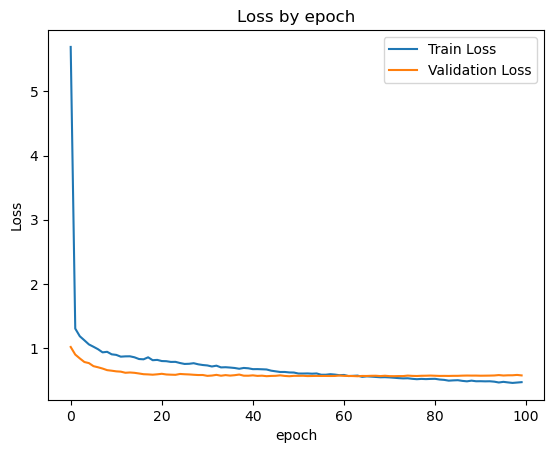

In [26]:
# Grafica loss por epoch
fig, ax1= plt.subplots(1,1)
ax1.plot(train_loss_by_epoch, label="Train Loss")
ax1.plot(valid_loss_by_epoch, label="Validation Loss")
ax1.legend()
ax1.set_title("Loss by epoch")
ax1.set_xlabel("epoch")
ax1.set_ylabel("Loss")



(0.5, 1.5)

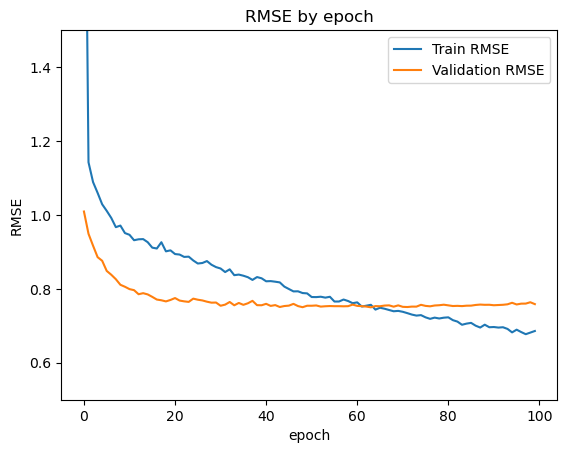

In [27]:
# Grafica loss por epoch
fig, ax1= plt.subplots(1,1)
ax1.plot(train_rmse_by_epoch, label="Train RMSE")
ax1.plot(valid_rmse_by_epoch, label="Validation RMSE")
ax1.legend()
ax1.set_title("RMSE by epoch")
ax1.set_xlabel("epoch")
ax1.set_ylabel("RMSE")
# Ajustar el rango del eje y
ax1.set_ylim(0.5, 1.5)


Varios comentarios se pueden hacer de esta red neuronal:

1. La métrica de evaluación del modelo RMSE terminó cerrando en 0,8 aprox, teniendo en cuenta que la desviación estándar del modelo es 1 y el rango de ratings es 5, no parece ser un muy buen modelo para predecir.
2. Por otro lado, de acuerdo a la muy poca información que teniamos (id de usarios e id de peliculas) logramos contruir un modelo que puede predecir ratings. Si contaramos con más features que definieran la película seguramente pudieramos mejorar el modelo.
3. Con respecto a la red en sí, se puede observar que el modelo esta overfitteando a partir de la época 80 aproximadamente. Luego en la parte de optimización volveremos a este tema.

## Definición de funciones de predicción

En primer lugar se nos pide definir una función capaz de recibir un usuario al azar, una cantidad "p" de películas que dicho usuario haya puntuado y verificar la predicción del modelo. Comparar con los puntajes reales contra los que el usuario asignó a dicha/s película/s.

In [28]:
#Genero el dataset que voy a utilizar en las predicciones
movies_df['userIdx']=user_idx
movies_df['movieIdx']=movie_idx

movies_df

,userId,movieId,rating,timestamp,userIdx,movieIdx
1772,18,1,3.5,1455209816,0,0
1773,18,2,3.0,1455617462,0,1
1774,18,6,4.0,1460138360,0,2
1775,18,16,4.5,1461311583,0,3
1776,18,32,4.0,1455209840,0,4
...,...,...,...,...,...,...
100326,610,60069,4.5,1493844866,62,187
100371,610,68157,5.0,1493845023,62,129
100380,610,68954,3.5,1493844881,62,130
100417,610,72998,4.5,1479544106,62,131


In [29]:
# Función para seleccionar un usuario al azar
def user_random(users):
    return np.random.choice(users)

# Función para seleccionar p cantidad de películas rateadas por el usuario
def movie_random_ratings_user(movies_df, random_user):
    # Filtro las películas rateadas por el usuario
    user_movies = movies_df[movies_df["userIdx"] == random_user]
    
    # Cuento la cantidad de películas rateadas por el usuario
    cantidad_peliculas_rateadas_usuario = user_movies.shape[0]
    
    if cantidad_peliculas_rateadas_usuario == 0:
        return []

    # Genero un número random entre 1 y el total de películas rateadas
    cantidad_peliculas_para_testear = np.random.randint(1, cantidad_peliculas_rateadas_usuario + 1)
    
    # Selecciono las películas de manera aleatoria sin reemplazo
    selected_movies = np.random.choice(user_movies['movieIdx'], size=cantidad_peliculas_para_testear, replace=False)
    
    return selected_movies


In [30]:
def prediccion_usuario (user, selected_movies, nnnet):
    # Filtro para quedarme con un dataset que solo contenga los ratings que quiero
    user_df = movies_df[(movies_df["userIdx"] == user) & (movies_df["movieIdx"].isin(selected_movies))].reset_index(drop=True)
    
    ###################################################
    ## Predicción
    ###################################################
    
    # Convierto los índices del usuario y películas a tensores de PyTorch
    user_tensor = torch.tensor(user_df["userIdx"], dtype=torch.long).to(device).int()
    selected_movies_tensor = torch.tensor(user_df["movieIdx"], dtype=torch.long).to(device).int()

    # Realizo la predicción
    ratings_prediction = nnnet(user_tensor, selected_movies_tensor)
    ratings_prediction = ratings_prediction.detach().cpu().numpy()

    # df de comparación entre real y prediccion
    df_comparacion = user_df.copy()
    df_comparacion["rating_pred"] = np.squeeze(ratings_prediction)
    
    return df_comparacion

In [31]:
# Ejemplo de uso de la función

usuario_aleatorio = user_random(user_idx)
peliculas_seleccionadas = movie_random_ratings_user(movies_df, usuario_aleatorio)
prediccion_nnet = prediccion_usuario(usuario_aleatorio, peliculas_seleccionadas, nnnetWithEmbeddings)

print("Usuario seleccionado:", usuario_aleatorio)
print("Películas seleccionadas:", peliculas_seleccionadas)
prediccion_nnet

Usuario seleccionado: 42
Películas seleccionadas: [ 20  64  70 160  40  44  80  95 143 144  53  13  55  50  24  57 163  59
  90  85   8 106  45  78 149 129  94   6 107 142  14  67 181  12 151 147
 130  87 174   7 199]


,userId,movieId,rating,timestamp,userIdx,movieIdx,rating_pred
0,448,47,4.0,1019132386,42,6,4.132025
1,448,50,4.0,1064741727,42,7,4.401157
2,448,104,3.0,1221250916,42,8,3.198957
3,448,208,2.0,1019124858,42,12,2.852320
4,448,223,4.0,1059407171,42,13,3.796079
5,448,231,3.0,1019128257,42,14,3.065443
6,448,329,4.0,1092829881,42,20,3.244864
7,448,357,3.0,1019127559,42,142,3.738418
8,448,367,3.0,1019127943,42,24,3.068887
9,448,410,4.0,1019128484,42,143,3.353617


Para comparar mejor la calidad de la predicción grafiquemos rating real vs predicción

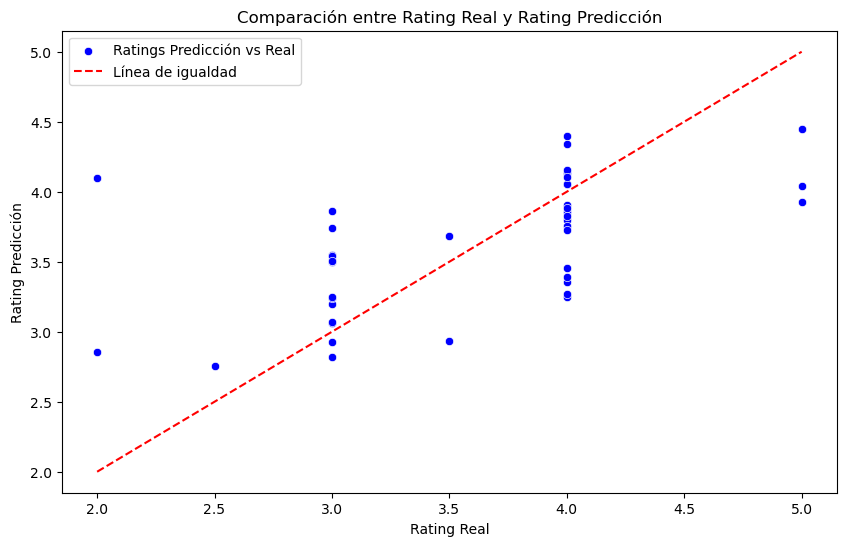

RMSE de la predicción:0.5750723965249517


In [32]:
import seaborn as sns
plt.figure(figsize=(10, 6))
    
# Crear la gráfica de dispersión
sns.scatterplot(x='rating', y='rating_pred', data=prediccion_nnet, color='blue', label='Ratings Predicción vs Real')
    
# Añadir una línea diagonal de referencia
plt.plot([prediccion_nnet['rating'].min(), prediccion_nnet['rating'].max()],
             [prediccion_nnet['rating'].min(), prediccion_nnet['rating'].max()],
             'r--', label='Línea de igualdad')
    
# Etiquetas y título
plt.xlabel('Rating Real')
plt.ylabel('Rating Predicción')
plt.title('Comparación entre Rating Real y Rating Predicción')
plt.legend()
    
# Mostrar la gráfica
plt.show()

rmse = np.sqrt(mean_squared_error(prediccion_nnet["rating"], prediccion_nnet["rating_pred"]))
print(f"RMSE de la predicción:{rmse}")

Nota: Las conclusiones a tomar ahora son de acuerdo a un set de pruebas que hice, al correr el notebook podría darse el caso particular de que la predicción particular performe mejor.

Acá se puede notar lo que ya intuiamos al ver los resultados iniciales del modelo, y es que en general el modelo predice "a lo seguro" la mayoria de las predicciones rondan la media de ratings. Lo que si se puede notar es que en los valores extremos bajos y altos sí logra distinguirlos mejor.

Ahora se nos pide contruir una funcion capaz de realizar una recomendación de película para un usuario determinado utilizando los embeddings de usuario o los embeddings de películas. Comprobar si la recomendación es correcta haciendo una predicción del puntuaje con la red neuronal.

Mi idea para enfocar esta función va a ser elegir un usuario aleatorio, buscar una película aleatoria que le haya gustado (usando la función anterior), luego hacer una búsqueda de parámetros similares de los embeddings con la función cosine_similarity de pytorch y así encontrar una película parecida a la que le gusto al usuario para recomendarle.

In [44]:
import torch.nn.functional as F
 # Uso la función anteriormente creada para obtener películas aleatorias que haya rateado el usuario
peliculas_seleccionadas = movie_random_ratings_user(movies_df, usuario_aleatorio)
        
    # Me quedo con la película top rateada
user_df = movies_df[(movies_df["userIdx"] == usuario_aleatorio) & (movies_df["movieIdx"].isin(peliculas_seleccionadas))].reset_index(drop=True)
user_df = user_df.sort_values(by='rating', ascending=False)
top_movie = user_df.head(1)['movieIdx'].values[0]
     
    # Busco los pesos de los embeddings para esa película
embeddings_movie_weights = nnnetWithEmbeddings.embeddings_movie.weight.data
embeddings_top_movie = embeddings_movie_weights[top_movie]
    
    # Calculo la similitud de la película estudiando sus embeddings
similarities = F.cosine_similarity(embeddings_top_movie.unsqueeze(0), embeddings_movie_weights)

    # Me quedo con las 2 usuarios má similares (porque uno es él mismo)
_, top_user_indices = torch.topk(similarities, 2)

In [64]:
import torch.nn.functional as F

def recomendacion_pelicula_similar(random_user, nnnet, movies_df):
    # Uso la función anteriormente creada para obtener películas aleatorias que haya rateado el usuario
    selected_movies = movie_random_ratings_user(movies_df, random_user)
        
    # Me quedo con la película top rateada
    user_df = movies_df[(movies_df["userIdx"] == random_user) & (movies_df["movieIdx"].isin(selected_movies))].reset_index(drop=True)
    user_df = user_df.sort_values(by='rating', ascending=False)
    top_movie = user_df.head(1)['movieIdx'].values[0]
     
    # Busco los pesos de los embeddings para esa película
    embeddings_movie_weights = nnnet.embeddings_movie.weight.data
    embeddings_top_movie = embeddings_movie_weights[top_movie]
    
    # Excluyo las películas ya calificadas por el usuario
    user_rated_movie_indices = user_df['movieIdx'].tolist()
    remaining_movie_indices = [idx for idx in range(len(embeddings_movie_weights)) if idx not in user_rated_movie_indices]
    embeddings_movie_not_seen = embeddings_movie_weights[remaining_movie_indices]
    
    # Calculo la similitud de la película estudiando sus embeddings
    similarities = F.cosine_similarity(embeddings_top_movie.unsqueeze(0), embeddings_movie_not_seen)

    # Me quedo con la película más similar
    _, top_movie_indices = torch.topk(similarities, 1)

    # Excluir el propio user_id
    similar_movie = [remaining_movie_indices[idx.item()] for idx in top_movie_indices]
     
    return similar_movie

In [65]:
# Ejemplo de uso de la función
top_movie_indices = recomendacion_pelicula_similar(usuario_aleatorio, nnnetWithEmbeddings, movies_df)

print(f'Índice de las películas más similar a la película top, que el usuario no ha calificado: {top_movie_indices}')

Índice de las películas más similar a la película top, que el usuario no ha calificado: [194]


## 6. Optimización

Por último se nos pide hacer una optimización a la red neuronal entrenada, en particular voy a centrarme en el optimizador Adam. De acuerdo a la bibliografía [ADAM](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html) hay varios parámetros que nos podemos poner a tunear para la optimización, en particular, elegire el learning rate, el weight_decay y los momentos de primer y segundo orden.

In [66]:
# Voy a generar una búsqueda de grilla 
lr_list = [0.1, 0.01, 0.001]
weight_decay_list = [0.01, 0.0001, 0]
betas_list = [(0.9, 0.99), (0.99, 0.999), (0.9, 0.999)]

#Creo un dataframe de métricas
col = ['learning rate','weight_decay','Momentos','Train RMSE', 'Valid RMSE']
df_metricas = pd.DataFrame(columns=col)

for lr in lr_list:
    for weight_decay in weight_decay_list:
        for betas in betas_list:
            #Reinicializo mi red
            nnnetWithEmbeddings = NNetWithEmbeddings()
            nnnetWithEmbeddings = nnnetWithEmbeddings.to(device)
            
            loss_function = torch.nn.MSELoss(reduction='sum')
            #modifico el optimizador en cada iteración
            optimizer = torch.optim.Adam(nnnetWithEmbeddings.parameters(), lr=lr, weight_decay=weight_decay, betas=betas)
            
            # cantidad de epochs
            epochs = 100

            train_rmse_by_epoch=[]
            valid_rmse_by_epoch=[]

            # Doble loop algoritmo Mini-Batch
            for epoch in range(epochs):
  
                ############################################
                ## Entrenamiento
                ############################################
                nnnetWithEmbeddings.train(True)

                epoch_loss = 0
                epoch_y_hat = []
                epoch_y = []
  
                for i,data in enumerate(train_dataloader):
                    # Obtengo los datos del batch de entrenamiento
                    embed_user_batch, embed_movie_batch, y_batch = data
                    # Copio el batch al dispositivo donde entreno la red neuronal
                    embed_user_batch = embed_user_batch.to(device).int()
                    embed_movie_batch = embed_movie_batch.to(device).int()
                    y_batch = y_batch.to(device).float().reshape(-1, 1)

                    # Paso forward
                    # Limpio optimizer para empezar un nuevo cálculo de gradiente
                    optimizer.zero_grad()
                    nnet_output = nnnetWithEmbeddings(embed_user_batch, embed_movie_batch)
                    y_batch_hat = nnet_output
    
                    # Calculo el loss
                    loss = loss_function(nnet_output, y_batch)

                    # Backpropagation
                    loss.backward()

                    # Actualizar los parámetros
                    optimizer.step()

                    # Almaceno los valores reales y mis predicciones para cálcular las métricas
                    epoch_y += list(y_batch.detach().cpu().numpy())
                    epoch_y_hat += list(y_batch_hat.detach().cpu().numpy())


                ############################################
                ## Validación
                ############################################
                # Desactivo el cálculo de gradiente para validación
                nnnetWithEmbeddings.train(False)

                valid_epoch_loss = 0
                valid_epoch_y_hat = []
                valid_epoch_y = []

                for i,data in enumerate(valid_dataloader):
                    # Obtengo los datos del batch de validación
                    embed_user_batch, embed_movie_batch, y_batch = data
                    # Copio el batch al dispositivo donde entreno la red neuronal
                    embed_user_batch = embed_user_batch.to(device).int()
                    embed_movie_batch = embed_movie_batch.to(device).int()
                    y_batch = y_batch.to(device).float().reshape(-1, 1)

                    # Paso forward
                    nnet_output = nnnetWithEmbeddings(embed_user_batch, embed_movie_batch)
                    y_batch_hat = nnet_output
    
                    # Calculo el loss
                    loss = loss_function(nnet_output, y_batch)

                    # En validación no hago backpropagation!!

                    # Almaceno los valores reales y mis predicciones para cálcular las métricas
                    valid_epoch_y += list(y_batch.detach().cpu().numpy())
                    valid_epoch_y_hat += list(y_batch_hat.detach().cpu().numpy())
                    
            # Cálculo la métrica de la última epoch
            train_rmse = sqrt(mean_squared_error(epoch_y, epoch_y_hat))
            # Cálculo la métrica de la última epoch
            valid_rmse = sqrt(mean_squared_error(valid_epoch_y, valid_epoch_y_hat))
            ###########################################
            ## Impresión de resultados después de la última epoch
            ############################################
  
            df_metricas.loc[len(df_metricas)] = [lr, weight_decay, betas,train_rmse, valid_rmse]
  


Veamos como dieron las mejores métricas:

In [68]:
df_metricas.sort_values(by='Valid RMSE', ascending=True)

,learning rate,weight_decay,Momentos,Train RMSE,Valid RMSE
25,0.001,0.0000,"(0.99, 0.999)",0.711436,0.753385
23,0.001,0.0001,"(0.9, 0.999)",0.689678,0.755970
22,0.001,0.0001,"(0.99, 0.999)",0.702345,0.756963
21,0.001,0.0001,"(0.9, 0.99)",0.665756,0.761193
18,0.001,0.0100,"(0.9, 0.99)",0.647109,0.761428
26,0.001,0.0000,"(0.9, 0.999)",0.682627,0.762206
19,0.001,0.0100,"(0.99, 0.999)",0.679333,0.762685
20,0.001,0.0100,"(0.9, 0.999)",0.663268,0.766553
24,0.001,0.0000,"(0.9, 0.99)",0.646274,0.767847
15,0.010,0.0000,"(0.9, 0.99)",0.532939,0.804242


Como conclusiones finales podemos observar que si bien no hay mucha diferencia para lo que es lo que se busca en este modelo, solamente modificando hiperparámetros del optimizador tenemos una diferencia de un 20% entre la peor y mejor combinación.

1. Para los learning rates: se nota una clara mejoría en la performance del modelo para los valores más bajos, por lo que parece en este modelo en particular lr más altos le dan demasiado peso al gradiente del backpropagation en el entrenamiento y no "recorren la sábana" de dimensiones de la manera más adecuada para llegar a la optimización. Es interesante observar que para learning rates intermedios se da un claro caso de overfitting, pero para valores más altos de learning rate ni siquiera llega a overfittear.
2. En lo que respecta al weight_decay: no parece haber una clara tendencia de variación a la hora de mejorar la performance, lo cual es esperable pues la red es muy poco profunda.
3. Para los betas: igual que el caso anterior no parece notarse una claro cambio de la performance del modelo al modificar los parámetros por defecto asociados al modelo.

También quiero aclarar que habían otros hiperparámetros que seguramente impacten más en la optimización (cantidad de capas en la red, cantidad de neuronas por capa, dimensionalidad de los embeddings, dropout rate, etc) sin embargo, me interesé más en estudiar como pueden impactar los hiperparámetros del método de optimización sin modificar la arquitectura de la red. De acuerdo a esta premisa, si me quedo con un aprendizaje de siempre estudiar con distintos learning rates.